This script contains the code used to generate figures from PRS + GRS datasets,
as well as the code used to create and validate population stratification.

## Setup

### Variables

In [1]:
dataset_path = r"dataset.pkl"
Genotek_data_path = r"data_for_plot.csv"

### Imports and setup

In [2]:
import pickle

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import statsmodels.formula.api as smf

# Nicer seaborn plots

sns.set()
sns.set_context("paper")
sns.set_style("whitegrid")

### Helper function for Figures 1, 3

In [3]:
# Plotting helper
def two_sided_arrow(ax, x1, y1, x2, y2, width_unit=0.02):
    ax.arrow(x1, y1,
             x2-x1, y2-y1,
             shape="full", color="black",
             width=width_unit, head_length=25 * width_unit, head_width=8 * width_unit,
             length_includes_head=True, antialiased=True)
    ax.arrow(x2, y2,
             x1-x2, y1-y2,
             shape="full", color="black",
             width=width_unit, head_length=25 * width_unit, head_width=8 * width_unit,
             length_includes_head=True, antialiased=True)


### Load data

In [4]:
df = pickle.load(open(dataset_path, "rb"))
bins_order = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%',
              '60-70%', '70-80%', '80-90%', '90-100%']

## Analysis of the BMI PRS associations and interactions

### Figure 1
### BMI distribution of individuals, stratified by genetic risk

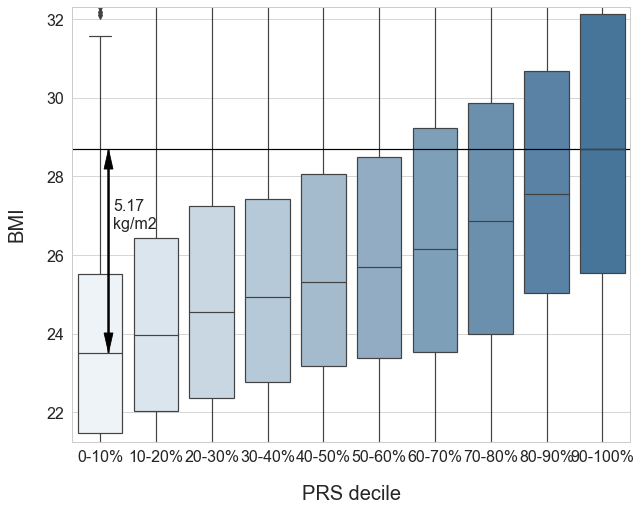

Difference in the average BMI between the top and the bottom deciles of people, according to their PRS, was 5.17 kg/m2.
Explained variance of 13.13% in a validation subset for PRS.


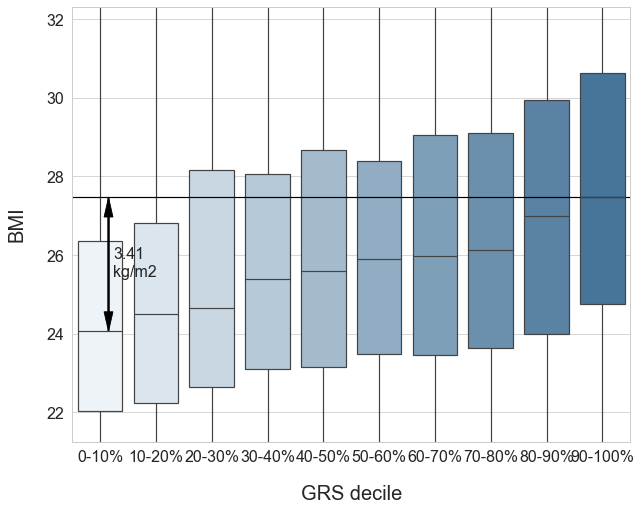

Difference in the average BMI between the top and the bottom deciles of people, according to their GRS, was 3.41 kg/m2.
Explained variance of 6.13% in a validation subset for GRS.


In [5]:
# Figure 1
for risk_score in ("PRS", "GRS"):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    sns.boxplot(data=df, x=f"{risk_score} decile", y="bmi",
                palette=sns.light_palette((57./255, 118./255, 167./255), input="rgb", n_colors=10),
                order=bins_order,
                ax=ax)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
    ax.set_ylim(list(df["bmi"].quantile((0.1, 0.9))))
    ax.set_xlabel(f"{risk_score} decile", fontsize=20, labelpad=20)
    ax.set_ylabel(f"BMI", fontsize=20, labelpad=20)
    low_median_bmi = df[df[f"{risk_score} decile"] == "0-10%"]["bmi"].median()
    high_median_bmi = df[df[f"{risk_score} decile"] == "90-100%"]["bmi"].median()
    ax.axhline(high_median_bmi, color='black')
    two_sided_arrow(ax, 0.15, low_median_bmi, 0.15, high_median_bmi)
    ax.text(0.23, high_median_bmi - 2,
            f"{high_median_bmi - low_median_bmi:.2f}\nkg/m2", fontsize=16)
    plt.show()
    # Measures
    pivot = df.pivot_table(index=f"{risk_score} decile", values="bmi", aggfunc=np.median)
    print(f'Difference in the average BMI between the top and the bottom deciles of people, according to their {risk_score}, '
          f'was {pivot.loc["90-100%", "bmi"] - pivot.loc["0-10%", "bmi"]:.2f} kg/m2.')
    # R2
    R2 = smf.ols(formula=f"bmi ~ 1 + {risk_score}", data=df).fit().rsquared
    print(f"Explained variance of {R2 * 100:.2f}% in a validation subset for {risk_score}.")

### Table 1
### Associations of the risk factors with BMI

In [6]:
# Table 1
operands = {
    "association": "+",
    "interaction": "*",
}
env_cut_off = 0.05 / 12
for risk_score in ("PRS", "GRS"):  # Only PRS results are present in the paper

    for analysis, op in operands.items():
        print(f"Analysis of BMI {risk_score} {analysis} with risk factors:")
        print(f"Significance cutoff is {env_cut_off:.2e}")
        for env, ref_group in [  # specifying which of the groups is considered a comparison group to the others
            ("smoking", 4),
            ("exercise", 1),
            ("alcohol", 0),
            ("dietquality", 1),
            ("social_class0", 5),
            ("mental", 1),
            ("sleep", 0),
        ]:
            m = smf.rlm(formula=f"bmi ~ 1 + {risk_score} {op} C({env}, Treatment(reference={ref_group})) + age + C(sex)", data=df).fit()
            index = m.pvalues.index.map(lambda x: x.startswith(f"C({env}"))
            if m.pvalues[index][m.pvalues[index] < env_cut_off].empty:
                print(f"No significant associations for {env} were found")
            else:
                print(f"Found significant associations for {env}")
            if analysis == "interaction":
                interaction_index = m.pvalues.index.map(lambda x: x.startswith(f"{risk_score}:C({env}"))
                if m.pvalues[interaction_index][m.pvalues[interaction_index] < env_cut_off].empty:
                    print(f"No significant interactions for {env} were found")
                else:
                    print(f"Found significant interactions for {env}")
                index = np.logical_or(index, interaction_index)
            report_df = pd.concat(
                {"p-value":m.pvalues[index],
                 "effect size":m.params[index],
                 "significant":m.pvalues[index].map(lambda x: "*" if x < env_cut_off else ""),
                 }, axis=1)
            print(report_df.to_string())
            print("---------------")
    print("\n\n")

Analysis of BMI PRS association with risk factors:
Significance cutoff is 4.17e-03
Found significant associations for smoking
                                                p-value  effect size significant
C(smoking, Treatment(reference=4))[T.1.0]  6.486057e-18    -1.055658           *
C(smoking, Treatment(reference=4))[T.2.0]  3.413707e-01     0.274068            
C(smoking, Treatment(reference=4))[T.3.0]  6.477063e-01     0.061604            
---------------
Found significant associations for exercise
                                                 p-value  effect size significant
C(exercise, Treatment(reference=1))[T.0.0]  8.487771e-13     0.793006           *
---------------
Found significant associations for alcohol
                                           p-value  effect size significant
C(alcohol, Treatment(reference=0))[T.1.0]   0.0009     -0.36202           *
---------------
No significant associations for dietquality were found
                                            

Found significant associations for exercise
No significant interactions for exercise were found
                                                     p-value  effect size significant
C(exercise, Treatment(reference=1))[T.0.0]      1.094762e-10     1.123453           *
GRS:C(exercise, Treatment(reference=1))[T.0.0]  4.493574e-02     0.742004            
---------------
Found significant associations for alcohol
No significant interactions for alcohol were found
                                                p-value  effect size significant
C(alcohol, Treatment(reference=0))[T.1.0]      0.000043    -0.707522           *
GRS:C(alcohol, Treatment(reference=0))[T.1.0]  0.068287    -0.656842            
---------------
No significant associations for dietquality were found
No significant interactions for dietquality were found
                                                    p-value  effect size significant
C(dietquality, Treatment(reference=1))[T.0.0]      0.894834    -0.023408          

### Figure 2
### BMI distribution of individuals, stratified by genetic risk and levels of physical activity

c:\python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()
c:\python36\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  app.launch_new_instance()


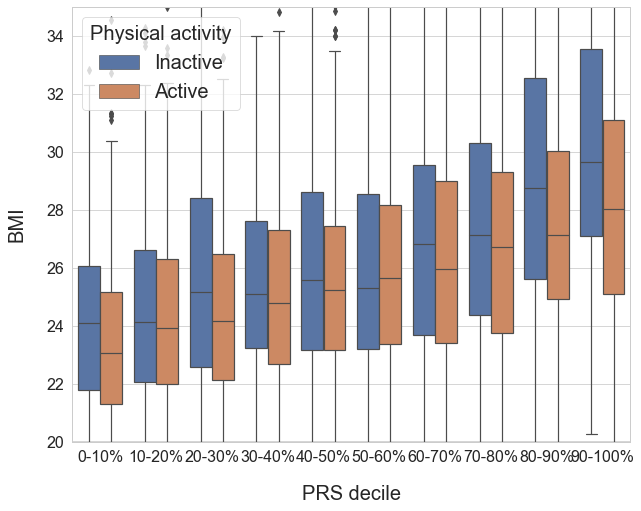

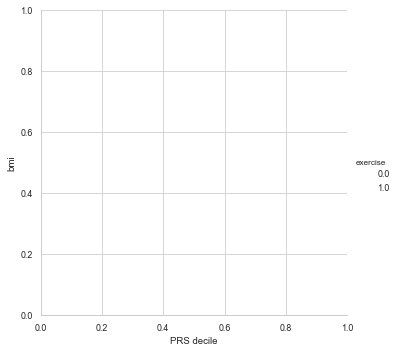

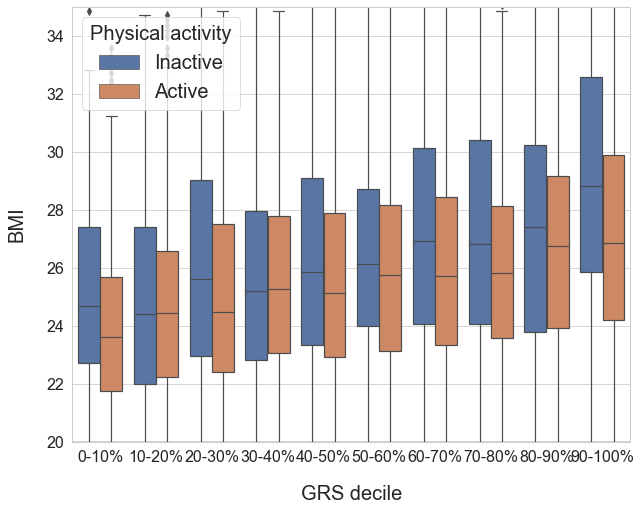

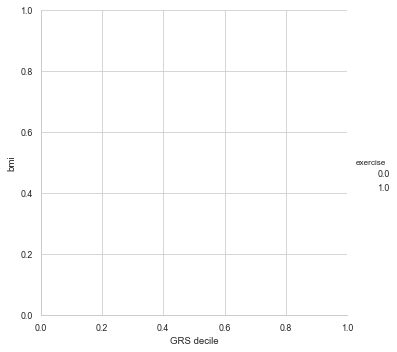

In [7]:
# Figure 2
for risk_score in ("PRS", "GRS"):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.catplot(data=df, x=f"{risk_score} decile", y="bmi", hue="exercise", kind="box", order=bins_order, ax=ax)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)
    ax.set_ylim((20,35))
    ax.set_xlabel(f"{risk_score} decile", fontsize=20, labelpad=20)
    ax.set_ylabel("BMI", fontsize=20, labelpad=20)
    legend = ax.legend(loc=2, fontsize=20, title_fontsize=20)  # <- required
    legend.set_title("Physical activity")
    assert legend.get_texts()[0].get_text() == "0.0"
    assert legend.get_texts()[1].get_text() == "1.0"
    legend.get_texts()[0].set_text("Inactive")
    legend.get_texts()[1].set_text("Active")
    fig.show()


## Making of stratification criterion

In [8]:
# Preparing models

# Standard model - effect of the exercise, no interaction
m0 = smf.ols(formula="bmi ~ 1 + age + C(sex) + PRS + C(exercise)", data=df).fit()

# Linear interaction model
mlin = smf.ols(formula="bmi ~ 1 + age + C(sex) + PRS + C(exercise) + PRS:C(exercise)", data=df).fit()
print(mlin.summary())
print(mlin.pvalues)

                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     208.1
Date:                Thu, 10 Dec 2020   Prob (F-statistic):          1.32e-201
Time:                        15:05:10   Log-Likelihood:                -13813.
No. Observations:                4859   AIC:                         2.764e+04
Df Residuals:                    4853   BIC:                         2.768e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 23

In [9]:
# Cut-off model - selection
# Regressing out covariates
mregrout = smf.ols(formula="bmi ~ 1 + age + C(sex)", data=df).fit()
df["bmi_resid"] = mregrout.resid
# Testing 100 models with different cut-offs
# Will take a bit of time
cutoffs = list(i * len(df["PRS"]) // 100 for i in range(100))
val_cutoffs = [list(sorted(df["PRS"]))[i] for i in cutoffs]
r2s = {}
for vc in val_cutoffs:
    df["indicator"] = (df["PRS"] > vc).map(int)
    m2 = smf.ols(formula="bmi_resid ~ 0 + PRS + C(exercise) + C(exercise):C(indicator)", data=df).fit()
    r2s[vc] = m2.rsquared
# Picking the best performing model
the_cutoff = pd.DataFrame(r2s.values(), index=r2s.keys())\
    .idxmax().values[0]
df["indicator"] = (df["PRS"] > the_cutoff).map(int)
# Reporting
print(f"PRS cutoff: {the_cutoff}")
print(f"Cutoff percentile: {(1. - np.mean(df['indicator'])) * 100:.0f}%")

PRS cutoff: 0.7828862143111658
Cutoff percentile: 78%


Resulting cut-off model
                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     178.7
Date:                Thu, 10 Dec 2020   Prob (F-statistic):          4.08e-206
Time:                        15:05:18   Log-Likelihood:                -13800.
No. Observations:                4859   AIC:                         2.761e+04
Df Residuals:                    4852   BIC:                         2.766e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

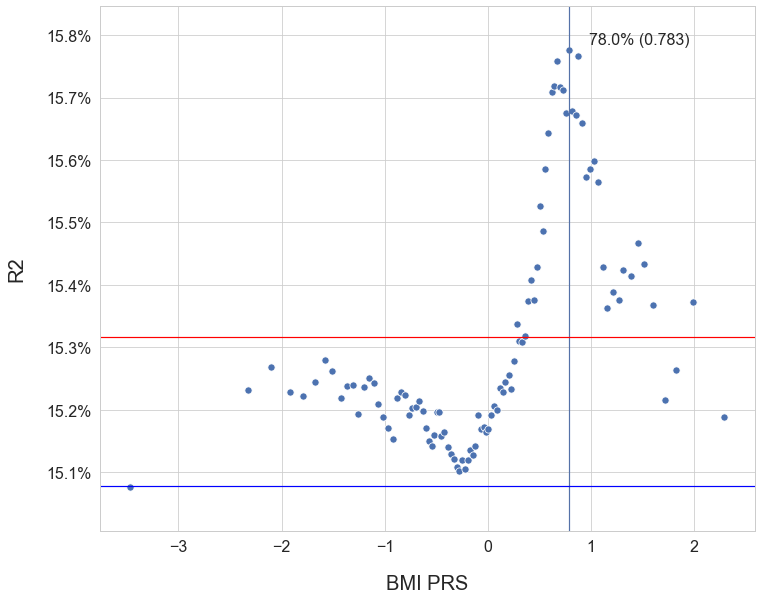

In [10]:
# Cut-off model
print("Resulting cut-off model")
mcutoff = smf.ols(formula="bmi ~ 1 + age + C(sex) + PRS + C(exercise) + C(exercise):C(indicator)", data=df).fit()
print(mcutoff.summary())
print(mcutoff.pvalues)

# Plotting selection criteria:
m0resid = smf.ols(formula="bmi_resid ~ 0 + PRS + C(exercise)", data=df).fit()
mlinresid = smf.ols(formula="bmi_resid ~ 0 + PRS + C(exercise) + PRS:C(exercise)", data=df).fit()
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 8))
df_r2 = pd.DataFrame(r2s.items())
# Plotting performance of each of the 100 models as a dot
sns.scatterplot(x=0, y=1, data=df_r2, ax=ax, s=52)
ax.axvline(the_cutoff, 0, 1, c=(85/255, 114/255, 168/255))
ax.text(the_cutoff + 0.2, max(df_r2[1]) + 0.0001,
        f"{(1. - np.mean(df['indicator'])) * 100:.1f}% ({the_cutoff:.3f})", fontsize=16)
fig.tight_layout()
interval = max(df_r2[1]) - min(df_r2[1])
ax.set_ylim(min(min(df_r2[1]), m0resid.rsquared, mlinresid.rsquared) - interval / 10,
            max(max(df_r2[1]), m0resid.rsquared, mlinresid.rsquared) + interval / 10,)
ax.set_xlabel("BMI PRS", fontsize=20, labelpad=20)
ax.set_ylabel("R2", fontsize=20, labelpad=20)
# Plotting comparison models performance (as lines)
ax.axhline(m0resid.rsquared, 0, 1, c="blue")
ax.axhline(mlinresid.rsquared, 0, 1, c="red")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(16)
ax.yaxis.set_major_formatter(PercentFormatter(1, decimals=1))
plt.show()
plt.close()

### Figure 3
### BMI distribution of individuals, stratified by PRS groups and levels of physical activity

#### Preparation

In [11]:
# Figure 3
# Data preparation
inactive = df["exercise"] == 0
active = df["exercise"] == 1
highrisk = df["indicator"] == 1
lowrisk = df["indicator"] == 0
df["inactive"] = inactive
df["active"] = active
df["highrisk"] = highrisk
df["lowrisk"] = lowrisk


#### Plotting Figure 3

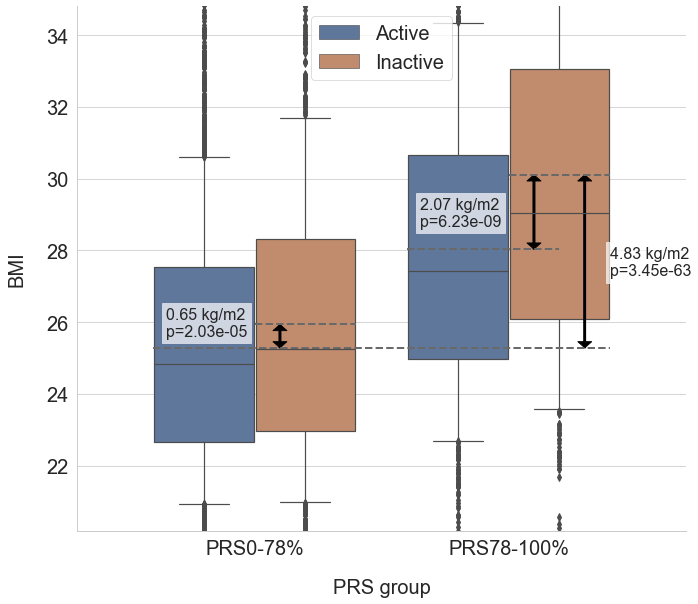

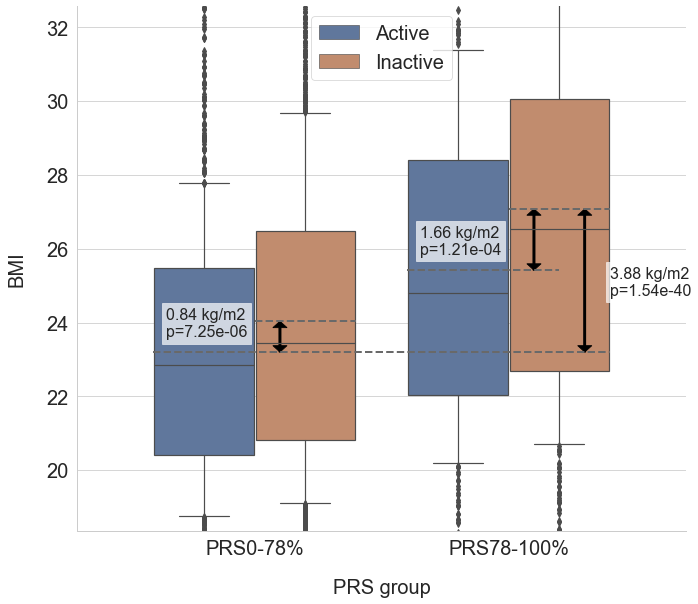

In [12]:
# Top panel
grid = sns.catplot(x="highrisk", y="bmi", hue="inactive", kind="box", data=df,
                   height=8, aspect=1.15, saturation=0.6,
                   ci=None, whis=[10, 90],
                   legend=False)  # to hide the standard legend
ax = grid.axes[0][0]
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
ax.set_xlabel("PRS group", fontsize=20, labelpad=20)
ax.set_ylabel("BMI", fontsize=20, labelpad=20)
ax.set_xticklabels(["PRS0-78%", "PRS78-100%"], fontsize=20)
ax.set_ylim(df["bmi"].quantile((0.05, 0.95)))
# ax.set_ylim((18, 35))
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ["Active", "Inactive"], fontsize=20, loc=9, borderaxespad=0.5)
means = [
    df[(df["lowrisk"]) & (df["active"])]["bmi"].mean(),
    df[(df["lowrisk"]) & (df["inactive"])]["bmi"].mean(),
    df[(df["highrisk"]) & (df["active"])]["bmi"].mean(),
    df[(df["highrisk"]) & (df["inactive"])]["bmi"].mean(),
]
ax.plot([-0.4, 1.4], [means[0], means[0]], color="dimgray", linestyle="dashed", lw=2)
ax.plot([0, 0.4], [means[1], means[1]], color="dimgray", linestyle="dashed", lw=2)
ax.plot([0.6, 1.2], [means[2], means[2]], color="dimgray", linestyle="dashed", lw=2)
ax.plot([1, 1.4], [means[3], means[3]], color="dimgray", linestyle="dashed", lw=2)
ph = "bmi"
two_sided_arrow(ax, 0.1, means[0], 0.1, means[1], width_unit=0.007)
two_sided_arrow(ax, 1.1, means[2], 1.1, means[3], width_unit=0.007)
two_sided_arrow(ax, 1.3, means[0], 1.3, means[3], width_unit=0.007)
_, p_inlowrisk = scipy.stats.ranksums(df.loc[lowrisk & active, ph].values, df.loc[lowrisk & inactive, ph].values)
_, p_inhighrisk = scipy.stats.ranksums(df.loc[highrisk & active, ph].values, df.loc[highrisk & inactive, ph].values)
_, p_both = scipy.stats.ranksums(df.loc[lowrisk & active, ph].values, df.loc[highrisk & inactive, ph].values)
ax.text(-0.35, (means[0] + means[1]) / 2,
        f"{means[1]-means[0]:.2f} kg/m2\np={p_inlowrisk:.2e}",
        fontsize=16, bbox=dict(facecolor='white', alpha=0.7))
ax.text(0.65, (means[2] + means[3]) / 2 - 0.4,
        f"{means[3]-means[2]:.2f} kg/m2\np={p_inhighrisk:.2e}",
        fontsize=16, bbox=dict(facecolor='white', alpha=0.7))
ax.text(1.4, (means[0] + means[3]) / 2 - 0.4,
        f"{means[3]-means[0]:.2f} kg/m2\np={p_both:.2e}",
        fontsize=16, bbox=dict(facecolor='white', alpha=0.7))
plt.show()
# Genotek data
df_replication = pd.read_table(Genotek_data_path, sep=None, engine='python').dropna()
df_replication["nonexercise"] = 1 - df_replication["physicalActivity"]
grid = sns.catplot(x="prs_bool", y="bmi", hue="nonexercise", kind="box", data=df_replication,
                   height=8, aspect=1.15, saturation=0.6,
                   ci=None, whis=[10, 90],
                   legend=False)  # to hide the standard legend
ax = grid.axes[0][0]
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
ax.set_xlabel("PRS group", fontsize=20, labelpad=20)
ax.set_ylabel("BMI", fontsize=20, labelpad=20)
ax.set_xticklabels(["PRS0-78%", "PRS78-100%"], fontsize=20)
ax.set_ylim(df_replication["bmi"].quantile((0.05, 0.95)))
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, ["Active", "Inactive"], fontsize=20, loc=9, borderaxespad=0.5)
means = [
    df_replication[(df_replication["prs_bool"] == risk) & (df_replication["nonexercise"] == nonex)]["bmi"].mean()
    for risk in (False, True)
    for nonex in (False, True)
]
ax.plot([-0.4, 1.4], [means[0], means[0]], color="dimgray", linestyle="dashed", lw=2)
ax.plot([0, 0.4], [means[1], means[1]], color="dimgray", linestyle="dashed", lw=2)
ax.plot([0.6, 1.2], [means[2], means[2]], color="dimgray", linestyle="dashed", lw=2)
ax.plot([1, 1.4], [means[3], means[3]], color="dimgray", linestyle="dashed", lw=2)
ph = "bmi"
two_sided_arrow(ax, 0.1, means[0], 0.1, means[1], width_unit=0.007)
two_sided_arrow(ax, 1.1, means[2], 1.1, means[3], width_unit=0.007)
two_sided_arrow(ax, 1.3, means[0], 1.3, means[3], width_unit=0.007)
rep_inactive = df_replication["physicalActivity"] == 0
rep_active = df_replication["physicalActivity"] == 1
rep_highrisk = df_replication["prs_bool"] == 1
rep_lowrisk = df_replication["prs_bool"] == 0
_, p_inlowrisk = scipy.stats.ranksums(df_replication.loc[rep_lowrisk & rep_active, ph].values, df_replication.loc[rep_lowrisk & rep_inactive, ph].values)
_, p_inhighrisk = scipy.stats.ranksums(df_replication.loc[rep_highrisk & rep_active, ph].values, df_replication.loc[rep_highrisk & rep_inactive, ph].values)
_, p_both = scipy.stats.ranksums(df_replication.loc[rep_lowrisk & rep_active, ph].values, df_replication.loc[rep_highrisk & rep_inactive, ph].values)
ax.text(-0.35, (means[0] + means[1]) / 2,
        f"{means[1]-means[0]:.2f} kg/m2\np={p_inlowrisk:.2e}",
        fontsize=16, bbox=dict(facecolor='white', alpha=0.7))
ax.text(0.65, (means[2] + means[3]) / 2 - 0.4,
        f"{means[3]-means[2]:.2f} kg/m2\np={p_inhighrisk:.2e}",
        fontsize=16, bbox=dict(facecolor='white', alpha=0.7))
ax.text(1.4, (means[0] + means[3]) / 2 - 0.4,
        f"{means[3]-means[0]:.2f} kg/m2\np={p_both:.2e}",
        fontsize=16, bbox=dict(facecolor='white', alpha=0.7))
plt.show()